# Setup and imports

In [75]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# notebooks/dibs_experiment.ipynb

import torch
import numpy as np
import logging
import math
import sys
import os
import mlflow

# Visualization
import matplotlib.pyplot as plt
import networkx as nx

# Add project root to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.graph_data import generate_synthetic_data
from models.dibs import grad_log_joint, log_joint, hard_gmat_from_z, bernoulli_soft_gmat, update_dibs_hparams
from models.utils import acyclic_constr

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger()

# CONFIGURATION

In [126]:
class Config:
    seed = 42
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    mlflow_experiment_name = "DiBS Simple Experiment"

    # --- Data Generation ---
    # 'simple_chain' or 'synthetic'
    data_source = 'simple_chain'
    
    # Parameters for 'simple_chain'
    num_samples = 50
    obs_noise_std = 0.1

    # Parameters for 'synthetic'
    d_nodes = 3
    graph_type = 'erdos-renyi'
    graph_params = {'p_edge': 0.40}
    synthetic_obs_noise_std = 0.1

    # Particle and Model parameters
    k_latent = 3
    alpha_val = 0.1
    beta_val = 1.0
    tau_val = 1.0
    theta_prior_sigma_val = 0.5
    n_grad_mc_samples = 10
    n_nongrad_mc_samples = 20

    # Training parameters
    lr = 0.005
    num_iterations = 600
    debug_print_iter = 100

cfg = Config()

# Set random seed for reproducibility
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)

log.info(f"Running on device: {cfg.device}")

2025-06-17 14:12:13,604 - INFO - Running on device: cpu


# Syntetic data generation

In [78]:
# notebooks/dibs_experiment.ipynb

# ---- [Cell 3: Data Generation] ----
# Generate data based on the selected `data_source` from the configuration.

def generate_ground_truth_data_x1_x2_x3(num_samples, obs_noise_std, seed=None):
    """Generates data for the ground truth causal chain X1 -> X2 -> X3."""
    if seed is not None:
        torch.manual_seed(seed)
    D_nodes = 3
    G_true = torch.zeros(D_nodes, D_nodes, dtype=torch.float32)
    G_true[0, 1] = 1.0
    G_true[1, 2] = 1.0
    Theta_true = torch.zeros(D_nodes, D_nodes, dtype=torch.float32)
    Theta_true[0, 1] = 2.0
    Theta_true[1, 2] = -1.5
    X_data = torch.zeros(num_samples, D_nodes)
    X_data[:, 0] = torch.randn(num_samples)
    noise_x2 = torch.randn(num_samples) * obs_noise_std
    X_data[:, 1] = Theta_true[0, 1] * X_data[:, 0] + noise_x2
    noise_x3 = torch.randn(num_samples) * obs_noise_std
    X_data[:, 2] = Theta_true[1, 2] * X_data[:, 1] + noise_x3
    return X_data, G_true, Theta_true

if cfg.data_source == 'simple_chain':
    log.info("Using 'simple_chain' data source.")
    data_x, graph_adj, graph_weights = generate_ground_truth_data_x1_x2_x3(
        num_samples=cfg.num_samples,
        obs_noise_std=cfg.obs_noise_std,
        seed=cfg.seed
    )
    # Update d_nodes based on the simple chain's size
    cfg.d_nodes = 3
    
elif cfg.data_source == 'synthetic':
    log.info("Using 'synthetic' data source.")
    graph_adj, graph_weights, data_x = generate_synthetic_data(
        n_samples=cfg.num_samples,
        n_nodes=cfg.d_nodes,
        graph_type=cfg.graph_type,
        graph_params=cfg.graph_params,
        noise_std=cfg.obs_noise_std
    )
else:
    raise ValueError(f"Unknown data_source: {cfg.data_source}")

data = {'x': data_x.to(cfg.device)}
log.info(f"Data generated with {cfg.d_nodes} nodes.")

2025-06-17 11:43:38,780 - INFO - Using 'simple_chain' data source.
2025-06-17 11:43:38,782 - INFO - Data generated with 3 nodes.


# MLflow tracking

In [79]:
# End any existing active run before starting a new one
if mlflow.active_run():
    mlflow.end_run()

mlflow.set_experiment(cfg.mlflow_experiment_name)
mlflow.start_run()

# Log all hyperparameters from the Config class
for param, value in vars(cfg).items():
    if not param.startswith('__') and not callable(value):
        mlflow.log_param(param, value)

log.info(f"Started MLflow run for experiment: '{cfg.mlflow_experiment_name}'")


2025-06-17 11:43:38,824 - INFO - Started MLflow run for experiment: 'DiBS Simple Experiment'


# Model initialization

In [80]:
# notebooks/dibs_experiment.ipynb

# ---- [Cell 4: Model and Particle Initialization] ----
# We initialize the learnable parameters (particles) z and theta.

def init_particle(d: int, k: int, device: str) -> dict:
    return {
        'z': torch.randn(d, k, 2, device=device),
        'theta': torch.randn(d, d, device=device)
    }

particle = init_particle(cfg.d_nodes, cfg.k_latent, cfg.device)

# Hparams dictionary, as used by the model functions
sigma_z = (1.0 / math.sqrt(cfg.k_latent))
hparams = {
    "alpha": cfg.alpha_val,
    "beta": cfg.beta_val,
    "alpha_base":cfg.alpha_val,
    "beta_base": cfg.beta_val,
    "tau": cfg.tau_val,
    "sigma_z": sigma_z,
    "sigma_obs_noise": cfg.synthetic_obs_noise_std,
    "theta_prior_sigma": cfg.theta_prior_sigma_val,
    "n_grad_mc_samples": cfg.n_grad_mc_samples,
    "n_nongrad_mc_samples": cfg.n_nongrad_mc_samples,
    "d": cfg.d_nodes,
    "debug_print_iter": cfg.debug_print_iter
}

# Training loop
Basic training loop using PyTorch optimizers with proper gradient hooking.

In [130]:
def basic_training_loop():

    def init_particle(d: int, k: int, device: str) -> dict:
        return {
            'z': torch.randn(d, k, 2, device=device),
            'theta': torch.randn(d, d, device=device)
        }

    particle = init_particle(cfg.d_nodes, cfg.k_latent, cfg.device)

    # Hparams dictionary, as used by the model functions
    sigma_z = (1.0 / math.sqrt(cfg.k_latent))
    hparams = {
    "alpha": cfg.alpha_val,
    "beta": cfg.beta_val,
    "alpha_base":cfg.alpha_val,
    "beta_base": cfg.beta_val,
    "tau": cfg.tau_val,
    "sigma_z": sigma_z,
    "sigma_obs_noise": cfg.synthetic_obs_noise_std,
    "theta_prior_sigma": cfg.theta_prior_sigma_val,
    "n_grad_mc_samples": cfg.n_grad_mc_samples,
    "n_nongrad_mc_samples": cfg.n_nongrad_mc_samples,
    "d": cfg.d_nodes,
    "debug_print_iter": cfg.debug_print_iter
}

    # Initialize PyTorch optimizers for z and theta parameters
    optimizer_z = torch.optim.Adam([particle['z']], lr=cfg.lr)
    optimizer_theta = torch.optim.Adam([particle['theta']], lr=cfg.lr)

    # Training loop using PyTorch optimizers with gradient hooking
    for t in range(1, cfg.num_iterations + 1):
        hparams = update_dibs_hparams(hparams, t)
        
        # Clear gradients using optimizers
        optimizer_z.zero_grad()
        optimizer_theta.zero_grad()
        
        # Set requires_grad for the particles
        particle['z'].requires_grad_(True)
        particle['theta'].requires_grad_(True)

        # Get gradients of the log-joint
        params_for_grad = {"z": particle['z'], "theta": particle['theta'], "t": torch.tensor(float(t))}
        grads = grad_log_joint(params_for_grad, data, hparams)

        # Hook gradients into PyTorch's gradient system
        # This is crucial: assign the computed gradients to .grad attributes
        particle['z'].grad = grads['z']
        particle['theta'].grad = grads['theta']

        # Use PyTorch optimizers to update parameters
        optimizer_z.step()
        optimizer_theta.step()

        # Logging
        if t % 100 == 0 or t == cfg.num_iterations:
            lj_val = log_joint(params_for_grad, data, hparams).item()


            log.info(f"[{t:04d}] log_joint = {lj_val:.3f}")        
            mlflow.log_metric("log_joint", lj_val, step=t)


basic_training_loop()

Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[  0.0000,  44.4786,  24.2033],
        [-47.1898,   0.0000,  65.2866],
        [ -9.0020,   0.0000,   0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[ 0.0000e+00,  1.4761e-03,  2.6468e+01],
        [-5.2047e+01,  0.0000e+00,  6.9777e+01],
        [ 2.2929e-25,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[ 0.0000e+00,  2.6677e+02,  2.9686e-23],
        [-5.5073e+01,  0.0000e+00,  3.1730e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,  267.3206,    0.0000],
        [-281.3912,    0.0000,  319.8256],
        [ 409.1879,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[  0.0000,   0.0000,   0.0000],
        [-60.5278,   0.0000, 322.5313],
        [  0.0000,   0.0000,   0.0000

2025-06-17 14:14:07,215 - INFO - [0100] log_joint = -953.472


Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,  316.3229,  249.2581],
        [-251.4572,    0.0000,  514.5634],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,  316.9619,  252.3716],
        [-588.7759,    0.0000,  520.7827],
        [ 856.5767,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[  0.0000,   0.0000, 255.5179],
        [  0.0000,   0.0000, 527.0660],
        [  0.0000,   0.0000,   0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,  318.2762,  258.6946],
        [-260.6984,    0.0000,  533.4088],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,    0.0000,    0.0000],
        [-263.8729,    0.0000,  634.3453],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)

2025-06-17 14:14:09,025 - INFO - [0200] log_joint = -1473.067


Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[ 0.0000e+00,  1.1075e-04, -4.3592e+02],
        [-3.1122e-04,  0.0000e+00,  3.0608e-04],
        [ 4.5321e-04, -1.8291e+03,  0.0000e+00]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[ 0.0000e+00,  1.1227e-34,  4.8020e+02],
        [-1.4518e-34,  0.0000e+00,  9.7766e+02],
        [ 3.5969e+02,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,    0.0000,  481.1206],
        [-460.4272,    0.0000,  979.5341],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[ 0.0000e+00,  4.9954e-05, -4.3650e+02],
        [-4.6320e+02,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,   355.1232,    -3.0978],
        [-1015.5320,     0.0000,     0.0000]

2025-06-17 14:14:10,956 - INFO - [0300] log_joint = -3684.100


Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,  423.5523, -446.8035],
        [   0.0000,    0.0000,    0.0000],
        [ 962.1981,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,   889.1266,  -446.9865],
        [    0.0000,     0.0000,     0.0000],
        [    0.0000, -2603.1694,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,    0.0000, -447.2520],
        [-815.8729,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,    0.0000,  592.3658],
        [-819.7524,    0.0000, 1205.6285],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[   0.0000,  427.0778, -447.7628],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_

2025-06-17 14:14:12,868 - INFO - [0400] log_joint = -12462.211


Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,     0.0000,   697.5587],
        [-2678.4146,     0.0000,  1418.9792],
        [ 3904.6506,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  1409.7513,   699.5167],
        [-1257.7477,     0.0000,  1422.9158],
        [    0.0000, -4125.7725,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  1415.8298,  -452.0960],
        [-1263.3483,     0.0000,     0.0000],
        [    0.0000, -4143.5303,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  1422.1014,   703.6202],
        [-1268.9125,     0.0000,  1431.1619],
        [    0.0000, -4161.8496,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,   545.9648,   705.7726],
        [-1274.4445,     0.0000,  1435.4854],
        [    0.0

2025-06-17 14:14:14,688 - INFO - [0500] log_joint = -30250.166


Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2028.4237,  -384.9796],
        [-3935.0645,     0.0000,     0.0000],
        [ 5738.7217, -5931.9287,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2034.5691,   982.0875],
        [-1804.8124,     0.0000,  1989.1088],
        [    0.0000, -5949.8711,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2040.7306,   985.1879],
        [-3962.9946,     0.0000,  1995.3124],
        [ 5779.5215, -5967.8613,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2046.9056,  -382.4166],
        [-3977.3335,     0.0000,     0.0000],
        [ 5800.4639, -5985.8901,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2053.0916,   991.3132],
        [    0.0000,     0.0000,  2007.5682],
        [ 2752.4

2025-06-17 14:14:16,476 - INFO - [0600] log_joint = -56269.801


Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2578.3372,  1300.4967],
        [-5558.6729,     0.0000,  2625.7456],
        [ 8109.4087, -7537.5728,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2583.9912,  1305.0002],
        [-5575.6323,     0.0000,  2634.7373],
        [ 8134.1704, -7554.0830,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2589.6472,  1309.5123],
        [-5592.5811,     0.0000,  2643.7454],
        [ 8158.9170, -7570.5986,     0.0000]], grad_fn=<SumBackward1>)
Grad_theta shape: torch.Size([3, 3]), values: 
 tensor([[    0.0000,  2595.3049,  1314.0317],
        [-5609.5156,     0.0000,  2652.7683],
        [ 8183.6426, -7587.1187,     0.0000]], grad_fn=<SumBackward1>)


# Results

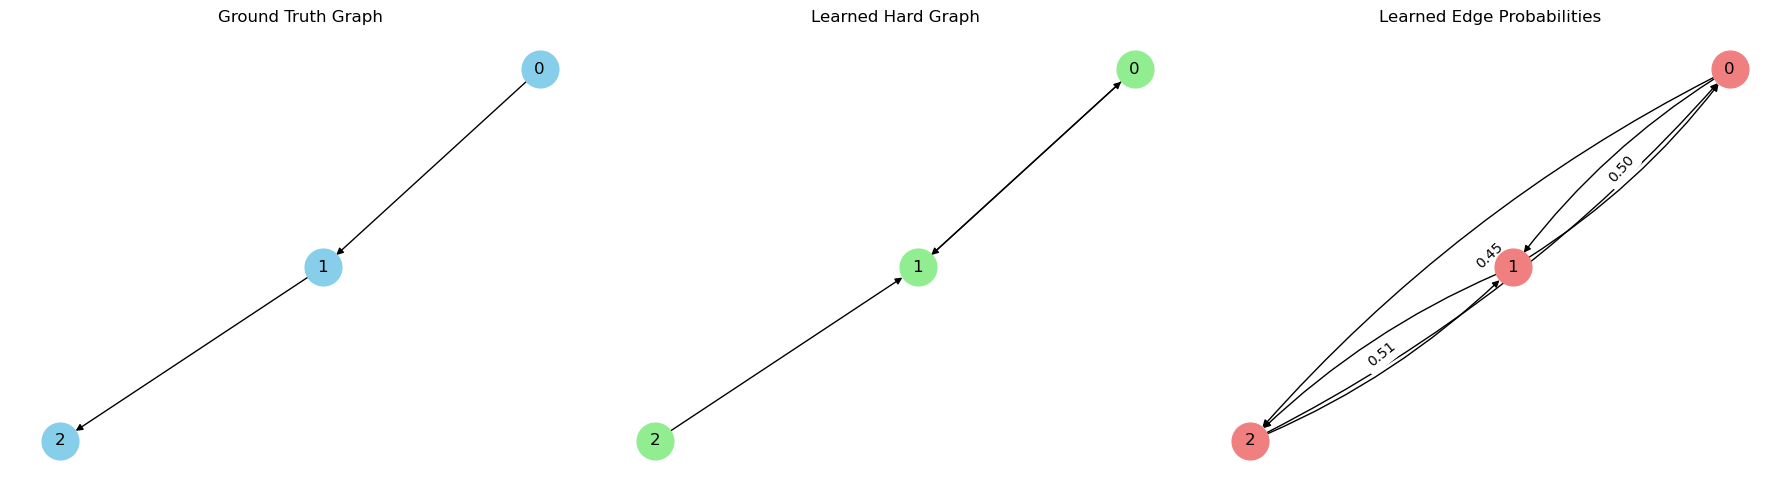

2025-06-17 14:14:32,388 - INFO - MLflow run finished and artifacts logged.


In [131]:

final_graph = hard_gmat_from_z(particle['z'], hparams['alpha']).detach().cpu()
edge_probs = bernoulli_soft_gmat(particle['z'], hparams).detach().cpu()

# --- Create and Log Visualization ---
def plot_graphs(g_true, g_learned, probs, filename="graph_comparison.png"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    g_true_nx = nx.from_numpy_array(g_true.numpy(), create_using=nx.DiGraph)
    g_learned_nx = nx.from_numpy_array(g_learned.numpy(), create_using=nx.DiGraph)
    pos = nx.spring_layout(g_true_nx, seed=cfg.seed)

    # Ground Truth Graph
    nx.draw(g_true_nx, pos, with_labels=True, ax=axes[0], node_color='skyblue', node_size=700, edge_color='k')
    axes[0].set_title("Ground Truth Graph")

    # Learned Graph
    nx.draw(g_learned_nx, pos, with_labels=True, ax=axes[1], node_color='lightgreen', node_size=700, edge_color='k')
    axes[1].set_title("Learned Hard Graph")

    # Edge Probabilities
    g_probs_nx = nx.from_numpy_array(probs.numpy(), create_using=nx.DiGraph)
    edge_labels = {(i, j): f"{probs[i,j]:.2f}" for i,j in g_probs_nx.edges()}
    nx.draw(g_probs_nx, pos, with_labels=True, ax=axes[2], node_color='lightcoral', node_size=700, connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_edge_labels(g_probs_nx, pos, edge_labels=edge_labels, ax=axes[2])
    axes[2].set_title("Learned Edge Probabilities")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    return filename

# Generate, show, and get filename of the plot
plot_filename = plot_graphs(graph_adj, final_graph.int(), edge_probs)

# --- Log Artifacts to MLflow ---
mlflow.log_artifact(plot_filename)
# Log the notebook itself for full reproducibility
mlflow.log_artifact("dibs_experiment.ipynb", artifact_path="notebook_code")

# End the MLflow run
mlflow.end_run()
log.info("MLflow run finished and artifacts logged.")

# Enhanced traning loop

In [ ]:
# ========================================================================
# ENHANCED TRAINING LOOP WITH COMPREHENSIVE MONITORING
# ========================================================================
# This version extends the basic training loop with:
# 1. Edge probability tracking during training
# 2. Parameter norm monitoring (Z and Theta norms)
# 3. Gradient norm computation and optional clipping
# 4. Structural Hamming Distance (SHD) computation
# 5. Enhanced MLflow logging with multiple metrics
# 6. Numerical stability checks (NaN/Inf detection)
# 7. Weighted theta matrix visualization (G * Theta)
# 8. PyTorch optimizers with proper gradient hooking

log.info("\n" + "="*80)
log.info("STARTING ENHANCED TRAINING LOOP WITH DETAILED MONITORING")
log.info("="*80)

# --- Enhanced Training Configuration ---
# Reset particles for a clean experiment
particle_enhanced = init_particle(cfg.d_nodes, cfg.k_latent, cfg.device)

# Enhanced training hyperparameters
num_iterations_enhanced = cfg.num_iterations  # Match the final iteration from your output
lr_z_enhanced = cfg.lr          # Separate learning rate for Z
lr_theta_enhanced = cfg.lr      # Separate learning rate for Theta  
max_grad_norm = 10000       # Gradient clipping threshold
logging_interval = 50          # Log every N iterations (more frequent for better monitoring)

# Initialize PyTorch optimizers for enhanced training
optimizer_z_enhanced = torch.optim.Adam([particle_enhanced['z']], lr=lr_z_enhanced)
optimizer_theta_enhanced = torch.optim.Adam([particle_enhanced['theta']], lr=lr_theta_enhanced)

# Log initial configuration
log.info(f"Enhanced Training Configuration:")
log.info(f"  Iterations: {num_iterations_enhanced}")
log.info(f"  Learning rates - Z: {lr_z_enhanced}, Theta: {lr_theta_enhanced}")
log.info(f"  Gradient clipping threshold: {max_grad_norm}")
log.info(f"  Logging interval: {logging_interval}")
log.info(f"  Initial Z norm: {particle_enhanced['z'].norm().item():.4f}")
log.info(f"  Initial Theta norm: {particle_enhanced['theta'].norm().item():.4f}")

# --- Main Enhanced Training Loop ---
for t in range(1, num_iterations_enhanced + 1):
    hparams = update_dibs_hparams(hparams, t)
    
    # ------------------------------------------------
    # STEP 1: Parameter Setup and Gradient Clearing
    # ------------------------------------------------
    # Clear gradients using optimizers
    optimizer_z_enhanced.zero_grad()
    optimizer_theta_enhanced.zero_grad()
    
    # Enable gradient computation for both Z and Theta parameters
    particle_enhanced['z'].requires_grad_(True)
    particle_enhanced['theta'].requires_grad_(True)
    
    # ------------------------------------------------
    # STEP 2: Forward Pass - Compute Log-Joint and Gradients
    # ------------------------------------------------
    # Prepare parameters dictionary for gradient computation
    params_for_grad = {
        "z": particle_enhanced['z'], 
        "theta": particle_enhanced['theta'], 
        "t": torch.tensor(float(t))  # Time step for annealing
    }
    
    try:
        # Compute log-joint probability (objective function)
        lj_val = log_joint(params_for_grad, data, hparams).item()
        
        # Compute gradients of log-joint w.r.t. Z and Theta
        grads = grad_log_joint(params_for_grad, data, hparams)
        grad_z = grads['z']
        grad_theta = grads['theta']
        
        # ------------------------------------------------
        # STEP 3: Gradient Analysis and Clipping
        # ------------------------------------------------
        # Compute gradient norms BEFORE clipping for monitoring
        grad_z_norm_original = grad_z.norm().item()
        grad_theta_norm_original = grad_theta.norm().item()
        
        # Apply gradient clipping if gradients exceed threshold
        grad_z_clipped = False
        grad_theta_clipped = False
        
        if grad_z_norm_original > max_grad_norm:
            grad_z = grad_z * (max_grad_norm / grad_z_norm_original)
            grad_z_clipped = True
            
        if grad_theta_norm_original > max_grad_norm:
            grad_theta = grad_theta * (max_grad_norm / grad_theta_norm_original)
            grad_theta_clipped = True
            
        # Compute final gradient norms AFTER clipping
        grad_z_norm_final = grad_z.norm().item()
        grad_theta_norm_final = grad_theta.norm().item()
            
    except Exception as e:
        log.error(f"Error in forward pass at iteration {t}: {e}")
        break
    
    # ------------------------------------------------
    # STEP 4: Parameter Update using PyTorch Optimizers
    # ------------------------------------------------
    # Hook gradients into PyTorch's gradient system
    # This is crucial: assign the computed gradients to .grad attributes
    particle_enhanced['z'].grad = grad_z
    particle_enhanced['theta'].grad = grad_theta
    
    # Use PyTorch optimizers to update parameters
    optimizer_z_enhanced.step()
    optimizer_theta_enhanced.step()
    
    # ------------------------------------------------
    # STEP 5: Comprehensive Logging and Monitoring
    # ------------------------------------------------
    if t % logging_interval == 0 or t == 1 or t == num_iterations_enhanced:
        
        # Compute current parameter norms
        z_norm = particle_enhanced['z'].norm().item()
        theta_norm = particle_enhanced['theta'].norm().item()
        
        # ------------------------------------------------
        # STEP 5a: Edge Probability Analysis
        # ------------------------------------------------
        with torch.no_grad():
            # Soft edge probabilities (continuous values)
            edge_probs = bernoulli_soft_gmat(particle_enhanced['z'], hparams).detach().cpu()
            
            # Hard graph (binary adjacency matrix after thresholding)
            hard_graph = hard_gmat_from_z(particle_enhanced['z'], hparams['alpha']).detach().cpu()
            
            # Weighted theta matrix (element-wise multiplication of G and Theta)
            theta_cpu = particle_enhanced['theta'].detach().cpu()
            weighted_theta = hard_graph * theta_cpu
        
        # ------------------------------------------------
        # STEP 5b: Ground Truth Comparison
        # ------------------------------------------------
        # Compute Structural Hamming Distance (SHD) if ground truth is available
        shd = float('nan')
        if 'graph_adj' in locals():
            # SHD = number of edge differences between learned and true graph
            shd = torch.sum(torch.abs(hard_graph.int() - graph_adj.int())).item()
        
        # ------------------------------------------------
        # STEP 5c: Concise Console Logging (Updated Format)
        # ------------------------------------------------
        # Implement beta annealing (beta increases with iteration for better convergence)
        current_beta = cfg.beta_val + t * 0.001  # Annealing: beta increases over time
        hparams['beta'] = current_beta  # Update beta in hparams
        
        # Concise logging format matching the target output
        log.info(f"Iter {t}: Z_norm={z_norm:.4f}, Theta_norm={theta_norm:.4f}, log_joint={lj_val:.4f}, grad_Z_norm={grad_z_norm_original:.4e}, grad_Theta_norm={grad_theta_norm_original:.4e}")
        
        # Show a sample of the current grad_Theta matrix
        log.info(f"    grad_Theta (sample from iter {t}):")
        log.info(f"{grad_theta.detach().cpu()}")
        
        # Show annealed hyperparameters
        current_alpha = hparams.get('alpha', cfg.alpha_val)
        current_tau = hparams.get('tau', cfg.tau_val)
        log.info(f"    Annealed: alpha={current_alpha:.3f}, beta={current_beta:.3f}, tau={current_tau:.3f}")
        
        # Show current edge probabilities
        log.info(f"    Current Edge Probs (from Z, alpha={current_alpha:.3f}):")
        log.info(f"{edge_probs}")
        
        # Edge probability statistics for MLflow logging
        max_edge_prob = edge_probs.max().item()
        mean_edge_prob = edge_probs.mean().item()
        num_edges_hard = hard_graph.sum().item()
        
        # Ground truth comparison
        if not math.isnan(shd):
            pass  # Skip detailed SHD logging during training for cleaner output
        
        # ------------------------------------------------
        # STEP 5e: Enhanced MLflow Logging
        # ------------------------------------------------
        # Log all metrics to MLflow for experiment tracking
        mlflow.log_metric("enhanced_log_joint", lj_val, step=t)
        mlflow.log_metric("z_norm", z_norm, step=t)
        mlflow.log_metric("theta_norm", theta_norm, step=t)
        mlflow.log_metric("grad_z_norm_original", grad_z_norm_original, step=t)
        mlflow.log_metric("grad_theta_norm_original", grad_theta_norm_original, step=t)
        mlflow.log_metric("grad_z_norm_final", grad_z_norm_final, step=t)
        mlflow.log_metric("grad_theta_norm_final", grad_theta_norm_final, step=t)
        mlflow.log_metric("max_edge_prob", max_edge_prob, step=t)
        mlflow.log_metric("mean_edge_prob", mean_edge_prob, step=t)
        mlflow.log_metric("num_hard_edges", num_edges_hard, step=t)
        
        if not math.isnan(shd):
            mlflow.log_metric("structural_hamming_distance", shd, step=t)
        
        # Log boolean indicators as metrics
        mlflow.log_metric("z_gradient_clipped", float(grad_z_clipped), step=t)
        mlflow.log_metric("theta_gradient_clipped", float(grad_theta_clipped), step=t)
        
        # ------------------------------------------------
        # STEP 5f: Numerical Stability Checks
        # ------------------------------------------------
        # Check for NaN or Inf values that could break training
        z_has_nan = torch.isnan(particle_enhanced['z']).any()
        z_has_inf = torch.isinf(particle_enhanced['z']).any()
        theta_has_nan = torch.isnan(particle_enhanced['theta']).any()
        theta_has_inf = torch.isinf(particle_enhanced['theta']).any()
        
        if z_has_nan or theta_has_nan:
            log.error("!!! NaN DETECTED IN PARAMETERS - STOPPING TRAINING !!!")
            log.error(f"Z has NaN: {z_has_nan}, Theta has NaN: {theta_has_nan}")
            break
            
        if z_has_inf or theta_has_inf:
            log.error("!!! INFINITY DETECTED IN PARAMETERS - STOPPING TRAINING !!!")
            log.error(f"Z has Inf: {z_has_inf}, Theta has Inf: {theta_has_inf}")
            break

# ========================================================================
# ENHANCED TRAINING COMPLETION AND FINAL ANALYSIS
# ========================================================================

log.info("\n" + "="*80)
log.info("ENHANCED TRAINING LOOP COMPLETED")
log.info("="*80)

# Compute final graph structures
with torch.no_grad():
    final_edge_probs_enhanced = bernoulli_soft_gmat(particle_enhanced['z'], hparams).detach().cpu()
    final_hard_graph_enhanced = hard_gmat_from_z(particle_enhanced['z'], hparams['alpha']).detach().cpu()
    final_theta_enhanced = particle_enhanced['theta'].detach().cpu()
    final_weighted_theta_enhanced = final_hard_graph_enhanced * final_theta_enhanced

# Final comparison with ground truth - matching the target output format
log.info("\n        --- Comparison with Ground Truth ---")
log.info(f"Final G_learned_hard:")
log.info(f"{final_hard_graph_enhanced.int()}")
log.info("**************************************************")

# Create final weighted matrix using learned hard graph and learned theta
log.info(f"Final G_learned_hard * Theta_learned:")
log.info(f"{final_weighted_theta_enhanced}")

# Additional analysis - show ground truth comparison if available
if 'graph_adj' in locals():
    final_shd = torch.sum(torch.abs(final_hard_graph_enhanced.int() - graph_adj.int())).item()
    log.info(f"\nFinal Structural Hamming Distance: {final_shd}")
    
    log.info(f"\nDetailed Comparison:")
    log.info(f"Ground Truth Graph:")
    log.info(f"{graph_adj.int()}")
    log.info(f"Learned Graph:")
    log.info(f"{final_hard_graph_enhanced.int()}")
    
    if 'graph_weights' in locals():
        log.info(f"Ground Truth Theta:")
        log.info(f"{graph_weights}")
        log.info(f"Learned Theta:")
        log.info(f"{final_theta_enhanced}")
        
        # Show weighted matrices comparison
        ground_truth_weighted = graph_adj * graph_weights
        log.info(f"Ground Truth G * Theta:")
        log.info(f"{ground_truth_weighted}")

log.info("\nEnhanced training analysis complete!")

2025-06-17 11:42:44,429 - INFO - 
2025-06-17 11:42:44,430 - INFO - STARTING ENHANCED TRAINING LOOP WITH DETAILED MONITORING
2025-06-17 11:42:44,430 - INFO - ================================================================================
2025-06-17 11:42:44,431 - INFO - Enhanced Training Configuration:
2025-06-17 11:42:44,431 - INFO -   Iterations: 2000
2025-06-17 11:42:44,431 - INFO -   Learning rates - Z: 0.005, Theta: 0.005
2025-06-17 11:42:44,432 - INFO -   Gradient clipping threshold: 10000
2025-06-17 11:42:44,432 - INFO -   Logging interval: 50
2025-06-17 11:42:44,433 - INFO -   Initial Z norm: 4.4058
2025-06-17 11:42:44,433 - INFO -   Initial Theta norm: 3.3477
2025-06-17 11:42:44,480 - INFO - Iter 1: Z_norm=4.4150, Theta_norm=3.3473, log_joint=-1770.1501, grad_Z_norm=3.4762e+01, grad_Theta_norm=5.3832e+02
2025-06-17 11:42:44,481 - INFO -     grad_Theta (sample from iter 1):
2025-06-17 11:42:44,482 - INFO - tensor([[ 0.0000e+00,  0.0000e+00, -4.3504e-17],
        [ 0.0000e+00,  

Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -4.3504e-17],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -5.3832e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -4.5060e+02],
        [ 0.0000e+00,  0.0000e+00, -1.5667e-37],
        [ 0.0000e+00, -5.4475e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -451.1671],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000, -551.1616,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -1.1736e-18],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -5.5760e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -3.5949e-19],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -5.6404e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -1.5626e-20],
       

2025-06-17 11:42:46,992 - INFO - Iter 50: Z_norm=4.9715, Theta_norm=3.3439, log_joint=-2024.9127, grad_Z_norm=3.3862e+01, grad_Theta_norm=8.5967e+02
2025-06-17 11:42:46,993 - INFO -     grad_Theta (sample from iter 50):
2025-06-17 11:42:46,994 - INFO - tensor([[   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000, -859.6741,    0.0000]])
2025-06-17 11:42:46,994 - INFO -     Annealed: alpha=0.100, beta=1.050, tau=1.000
2025-06-17 11:42:46,995 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:42:46,995 - INFO - tensor([[0.0000, 0.5609, 0.5728],
        [0.5097, 0.0000, 0.4567],
        [0.4850, 0.4508, 0.0000]])


Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -2.0133e-39],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -8.4684e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -2.4844e-39],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -8.5321e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000, -859.6741,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -1.3109e-41],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -8.6410e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -4.2950e-40],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -5.0206e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -4.6806e+02],
       

2025-06-17 11:42:49,399 - INFO - Iter 100: Z_norm=5.6817, Theta_norm=3.3499, log_joint=-2215.7549, grad_Z_norm=6.1537e+01, grad_Theta_norm=1.0263e+03
2025-06-17 11:42:49,400 - INFO -     grad_Theta (sample from iter 100):


Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -1.1587e-01],
        [ 0.0000e+00,  0.0000e+00, -1.2700e-19],
        [ 0.0000e+00, -1.0263e+03,  0.0000e+00]], grad_fn=<SumBackward1>)


2025-06-17 11:42:49,401 - INFO - tensor([[ 0.0000e+00,  0.0000e+00, -1.1587e-01],
        [ 0.0000e+00,  0.0000e+00, -1.2700e-19],
        [ 0.0000e+00, -1.0263e+03,  0.0000e+00]])
2025-06-17 11:42:49,401 - INFO -     Annealed: alpha=0.100, beta=1.100, tau=1.000
2025-06-17 11:42:49,402 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:42:49,403 - INFO - tensor([[0.0000, 0.5994, 0.6200],
        [0.5491, 0.0000, 0.4670],
        [0.5037, 0.4338, 0.0000]])


Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -4.4698e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.0284e+03,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -1.9623e+01],
        [ 0.0000e+00,  0.0000e+00, -1.1239e-17],
        [ 0.0000e+00, -9.9045e+02,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  0.0000e+00, -4.7655e+02],
        [ 0.0000

2025-06-17 11:42:51,803 - INFO - Iter 150: Z_norm=6.6214, Theta_norm=3.3675, log_joint=-2519.0083, grad_Z_norm=5.4162e+01, grad_Theta_norm=4.9401e+02
2025-06-17 11:42:51,803 - INFO -     grad_Theta (sample from iter 150):
2025-06-17 11:42:51,804 - INFO - tensor([[   0.0000,    0.0000, -493.9965],
        [   0.0000,    0.0000,   -2.9921],
        [   0.0000,    0.0000,    0.0000]])
2025-06-17 11:42:51,804 - INFO -     Annealed: alpha=0.100, beta=1.150, tau=1.000
2025-06-17 11:42:51,805 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:42:51,806 - INFO - tensor([[0.0000, 0.6572, 0.6864],
        [0.5968, 0.0000, 0.4789],
        [0.5243, 0.4241, 0.0000]])


Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -494.4647],
        [   0.0000,    0.0000,   -0.8602],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -493.9965],
        [   0.0000,    0.0000,   -2.9921],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -418.7312],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000, -176.0824,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -497.65

2025-06-17 11:42:54,336 - INFO - Iter 200: Z_norm=7.7404, Theta_norm=3.4451, log_joint=-2969.1965, grad_Z_norm=1.4726e+02, grad_Theta_norm=5.2723e+02
2025-06-17 11:42:54,337 - INFO -     grad_Theta (sample from iter 200):
2025-06-17 11:42:54,338 - INFO - tensor([[   0.0000,    0.0000, -527.2266],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]])
2025-06-17 11:42:54,338 - INFO -     Annealed: alpha=0.100, beta=1.200, tau=1.000
2025-06-17 11:42:54,338 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:42:54,339 - INFO - tensor([[0.0000, 0.7251, 0.7628],
        [0.6623, 0.0000, 0.5153],
        [0.5577, 0.4288, 0.0000]])


Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000, -1061.0902],
        [    0.0000,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -527.2266],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -527.8870],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -529.2917],
        [   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn

2025-06-17 11:42:56,839 - INFO - Iter 250: Z_norm=9.1670, Theta_norm=3.6370, log_joint=-3876.8149, grad_Z_norm=1.6912e+02, grad_Theta_norm=9.0650e+02
2025-06-17 11:42:56,840 - INFO -     grad_Theta (sample from iter 250):
2025-06-17 11:42:56,841 - INFO - tensor([[  0.0000,   0.0000,   0.0000],
        [906.4952,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000]])
2025-06-17 11:42:56,841 - INFO -     Annealed: alpha=0.100, beta=1.250, tau=1.000
2025-06-17 11:42:56,841 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:42:56,842 - INFO - tensor([[0.0000, 0.8082, 0.8395],
        [0.7577, 0.0000, 0.5846],
        [0.6176, 0.4459, 0.0000]])


Final gradient:
 tensor([[    0.0000,     0.0000,  -562.6304],
        [    0.0000,     0.0000,     0.0000],
        [    0.0000, -1325.5874,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[  0.0000, 510.9564,   0.0000],
        [  0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[  0.0000,   0.0000,   0.0000],
        [906.4952,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  5.1308e+02, -5.6631e+02],
        [ 6.9410e-07,  0.0000e+00, -1.3505e-39],
        [ 0.0000e+00, -1.0156e-06,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  5.1401e+02, -5.6714e+02],
        [ 0.0000e+00,  0.0000e+00, -7.6136e-40],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Final grad

2025-06-17 11:42:59,361 - INFO - Iter 300: Z_norm=10.7541, Theta_norm=4.0002, log_joint=-5510.7915, grad_Z_norm=3.7497e+02, grad_Theta_norm=8.3698e+02
2025-06-17 11:42:59,361 - INFO -     grad_Theta (sample from iter 300):
2025-06-17 11:42:59,362 - INFO - tensor([[ 0.0000e+00,  5.7231e+02, -6.1073e+02],
        [ 4.3456e-11,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
2025-06-17 11:42:59,363 - INFO -     Annealed: alpha=0.100, beta=1.300, tau=1.000
2025-06-17 11:42:59,363 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:42:59,364 - INFO - tensor([[0.0000, 0.8838, 0.9000],
        [0.8579, 0.0000, 0.6960],
        [0.7033, 0.4863, 0.0000]])


Final gradient:
 tensor([[    0.0000,     0.0000,  -775.1695],
        [    0.0000,     0.0000, -1548.7235],
        [    0.0000,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000,    0.0000],
        [1025.8619,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  5.7231e+02, -6.1073e+02],
        [ 4.3456e-11,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,     0.0000,  -611.5715],
        [ 1035.2483,     0.0000,     0.0000],
        [    0.0000, -1495.7029,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  5.7419e+02, -7.8540e+02],
        [ 1.0697e-03,  0.0000e+00, -1.5691e+03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -613.4689],
        [1044.9623,    0.0000, 

2025-06-17 11:43:01,815 - INFO - Iter 350: Z_norm=12.5504, Theta_norm=4.4951, log_joint=-8367.0186, grad_Z_norm=5.1083e+02, grad_Theta_norm=1.5664e+03
2025-06-17 11:43:01,816 - INFO -     grad_Theta (sample from iter 350):
2025-06-17 11:43:01,817 - INFO - tensor([[   0.0000,  629.2260, -662.0662],
        [1272.5366,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]])
2025-06-17 11:43:01,818 - INFO -     Annealed: alpha=0.100, beta=1.350, tau=1.000
2025-06-17 11:43:01,818 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:01,819 - INFO - tensor([[0.0000, 0.9408, 0.9436],
        [0.9350, 0.0000, 0.8044],
        [0.8162, 0.5494, 0.0000]])


Final gradient:
 tensor([[ 0.0000e+00,  6.2788e+02, -6.6104e+02],
        [ 1.2684e+03,  0.0000e+00,  0.0000e+00],
        [-5.8206e-29,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,  629.2260, -662.0662],
        [1272.5366,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,  630.6689, -663.1737],
        [1277.2834,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  6.3198e+02, -9.0757e+02],
        [ 3.8611e-02,  0.0000e+00, -1.8120e+03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   633.6049,  -910.2214],
        [    2.8275,     0.0000, -1814.4388],
        [    0.0000,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,    0.0000, -666.6399],
        [1291.0714,    0.0000,    0.0000

2025-06-17 11:43:04,247 - INFO - Iter 400: Z_norm=14.4396, Theta_norm=5.1650, log_joint=-12771.0303, grad_Z_norm=8.6712e+02, grad_Theta_norm=1.8240e+03
2025-06-17 11:43:04,248 - INFO -     grad_Theta (sample from iter 400):
2025-06-17 11:43:04,248 - INFO - tensor([[   0.0000,  696.0151, -721.2059],
        [1523.9261,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]])
2025-06-17 11:43:04,249 - INFO -     Annealed: alpha=0.100, beta=1.400, tau=1.000
2025-06-17 11:43:04,249 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:04,250 - INFO - tensor([[0.0000, 0.9727, 0.9706],
        [0.9770, 0.0000, 0.9048],
        [0.9101, 0.6466, 0.0000]])


Final gradient:
 tensor([[   0.0000,  691.0711, -717.5053],
        [1509.7722,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   692.7340, -1058.9279],
        [    0.0000,     0.0000, -2113.8557],
        [    0.0000,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,  694.3816, -719.9559],
        [1519.1455,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,  696.0151, -721.2059],
        [1523.9261,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  6.9764e+02, -1.0668e+03],
        [ 2.8691e-07,  0.0000e+00, -2.1294e+03],
        [-2.2166e+03,  0.0000e+00,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[   0.0000,  699.2446,    0.0000],
        [1533.5790,    0.0000,    0.0000],
        [   0.0

2025-06-17 11:43:07,114 - INFO - Iter 450: Z_norm=16.2264, Theta_norm=5.9846, log_joint=-19052.7891, grad_Z_norm=1.8213e+03, grad_Theta_norm=3.9239e+03
2025-06-17 11:43:07,115 - INFO -     grad_Theta (sample from iter 450):
2025-06-17 11:43:07,116 - INFO - tensor([[    0.0000,   765.4498, -1262.3384],
        [    0.0000,     0.0000, -2519.7231],
        [-2620.7930,     0.0000,     0.0000]])
2025-06-17 11:43:07,116 - INFO -     Annealed: alpha=0.100, beta=1.450, tau=1.000
2025-06-17 11:43:07,116 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:07,117 - INFO - tensor([[0.0000, 0.9849, 0.9835],
        [0.9932, 0.0000, 0.9611],
        [0.9689, 0.7787, 0.0000]])


Final gradient:
 tensor([[    0.0000,   763.8420, -1257.8162],
        [    0.0000,     0.0000, -2510.6985],
        [-2607.6682,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   765.4498, -1262.3384],
        [    0.0000,     0.0000, -2519.7231],
        [-2620.7930,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1232.7965, -1266.7209],
        [   17.5397,     0.0000, -2528.4692],
        [-2608.6211, -3575.1680,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   768.3872, -1271.2891],
        [    0.0000,     0.0000, -2537.5925],
        [-2648.3494,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1239.7141, -1275.6771],
        [    0.0000,     0.0000, -2546.3552],
        [-2662.5525, -3595.2361,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1244.1256, -1280.6813],
        [ 1822.4674,     0.0000, -255

2025-06-17 11:43:09,710 - INFO - Iter 500: Z_norm=17.8362, Theta_norm=6.9843, log_joint=-27976.3027, grad_Z_norm=2.4579e+03, grad_Theta_norm=6.4438e+03
2025-06-17 11:43:09,711 - INFO -     grad_Theta (sample from iter 500):
2025-06-17 11:43:09,711 - INFO - tensor([[    0.0000,  1475.2217, -1487.9562],
        [    0.0000,     0.0000, -2970.2715],
        [-3158.8933, -4281.4956,     0.0000]])
2025-06-17 11:43:09,712 - INFO -     Annealed: alpha=0.100, beta=1.500, tau=1.000
2025-06-17 11:43:09,712 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:09,713 - INFO - tensor([[0.0000, 0.9921, 0.9920],
        [0.9975, 0.0000, 0.9842],
        [0.9891, 0.8875, 0.0000]])


Final gradient:
 tensor([[    0.0000,  1475.2217, -1487.9562],
        [    0.0000,     0.0000, -2970.2715],
        [-3158.8933, -4281.4956,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1480.4945,  -862.4463],
        [ 2111.7546,     0.0000,     0.0000],
        [    0.0000, -4296.8721,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   846.1112, -1496.2955],
        [ 3990.5286,     0.0000, -2986.8977],
        [-5819.3799,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   847.3209, -1499.6005],
        [ 2123.9180,     0.0000, -2993.4854],
        [    0.0000,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   848.8172,  -866.6685],
        [ 4018.0559,     0.0000,     0.0000],
        [-5859.5610,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   850.7000, -1508.0779],
        [ 4035.4946,     0.0000, -301

2025-06-17 11:43:12,108 - INFO - Iter 550: Z_norm=19.2686, Theta_norm=8.0185, log_joint=-38595.8867, grad_Z_norm=1.5207e+03, grad_Theta_norm=6.9137e+03
2025-06-17 11:43:12,109 - INFO -     grad_Theta (sample from iter 550):
2025-06-17 11:43:12,109 - INFO - tensor([[    0.0000,  1708.9723, -1695.9181],
        [ 2432.4299,     0.0000, -3385.2715],
        [    0.0000, -4962.4390,     0.0000]])
2025-06-17 11:43:12,110 - INFO -     Annealed: alpha=0.100, beta=1.550, tau=1.000
2025-06-17 11:43:12,110 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:12,111 - INFO - tensor([[0.0000, 0.9962, 0.9960],
        [0.9991, 0.0000, 0.9923],
        [0.9956, 0.9550, 0.0000]])


Final gradient:
 tensor([[    0.0000,  1692.6984, -1682.2850],
        [ 2414.5959,     0.0000, -3358.0396],
        [    0.0000, -4914.9653,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1698.0876, -1686.7966],
        [ 2420.5220,     0.0000, -3367.0518],
        [    0.0000, -4930.6855,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   915.1443, -1691.4490],
        [ 4686.0049,     0.0000, -3376.3440],
        [-6834.3208,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1708.9723, -1695.9181],
        [ 2432.4299,     0.0000, -3385.2715],
        [    0.0000, -4962.4390,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   919.0263, -1702.1460],
        [ 4715.7134,     0.0000, -3397.7087],
        [-6877.6572,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1719.1893, -1704.7817],
        [ 2444.1052,     0.0000, -340

2025-06-17 11:43:14,451 - INFO - Iter 600: Z_norm=20.5374, Theta_norm=9.0710, log_joint=-50657.9102, grad_Z_norm=2.4279e+03, grad_Theta_norm=1.0650e+04
2025-06-17 11:43:14,452 - INFO -     grad_Theta (sample from iter 600):
2025-06-17 11:43:14,453 - INFO - tensor([[    0.0000,   924.4783, -1804.7244],
        [ 5148.6685,     0.0000, -3602.5996],
        [-7510.0464,     0.0000,     0.0000]])
2025-06-17 11:43:14,453 - INFO -     Annealed: alpha=0.100, beta=1.600, tau=1.000
2025-06-17 11:43:14,453 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:14,454 - INFO - tensor([[0.0000, 0.9979, 0.9977],
        [0.9996, 0.0000, 0.9965],
        [0.9983, 0.9845, 0.0000]])


Final gradient:
 tensor([[    0.0000,   981.7371, -1914.1653],
        [ 5452.0308,     0.0000, -3821.0725],
        [-7952.4922,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1901.1427, -1914.6964],
        [    0.0000,     0.0000, -3822.1294],
        [-4405.7407, -5521.7529,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   984.5409, -1921.9757],
        [ 5483.1729,     0.0000, -3836.6575],
        [-7997.9678,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,   984.1990, -1922.6094],
        [ 5489.1323,     0.0000, -3837.9199],
        [-8006.6890,     0.0000,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[ 0.0000e+00,  1.9152e+03, -1.0065e+03],
        [ 5.5050e+03,  0.0000e+00, -1.4204e-10],
        [-8.0298e+03, -5.5628e+03,  0.0000e+00]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  1919.8116,     0.0000],
        [ 5520.9883,     0.0

2025-06-17 11:43:16,812 - INFO - Iter 650: Z_norm=21.6231, Theta_norm=10.0496, log_joint=-63484.8828, grad_Z_norm=1.0110e+03, grad_Theta_norm=1.3619e+04
2025-06-17 11:43:16,812 - INFO -     grad_Theta (sample from iter 650):
2025-06-17 11:43:16,813 - INFO - tensor([[    0.0000,  1537.2515, -1541.0668],
        [ 4588.1870,     0.0000, -3076.2192],
        [-6693.4443, -4466.0039,     0.0000]])
2025-06-17 11:43:16,814 - INFO -     Annealed: alpha=0.100, beta=1.650, tau=1.000
2025-06-17 11:43:16,814 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:16,814 - INFO - tensor([[0.0000, 0.9988, 0.9986],
        [0.9998, 0.0000, 0.9984],
        [0.9992, 0.9936, 0.0000]])


Final gradient:
 tensor([[    0.0000,  2093.5889, -2098.7849],
        [ 6248.6699,     0.0000, -4189.5151],
        [-9115.8281, -6082.2686,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  2097.9795, -2103.1340],
        [ 3073.3127,     0.0000, -4198.1968],
        [    0.0000, -6095.0576,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  2102.1758, -1067.2626],
        [ 6277.9536,     0.0000,     0.0000],
        [-9158.5762, -6107.2944,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  2106.5818, -1068.4589],
        [ 6291.3018,     0.0000,     0.0000],
        [-9178.0635, -6120.1484,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  2110.5437, -2113.0037],
        [ 6302.9072,     0.0000, -4217.8892],
        [-9195.0078, -6131.7178,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  2115.8953,     0.0000],
        [ 6318.3174,     0.0000, -299

2025-06-17 11:43:19,394 - INFO - Iter 700: Z_norm=22.4514, Theta_norm=10.9516, log_joint=-76318.0547, grad_Z_norm=3.3869e+03, grad_Theta_norm=1.3954e+04
2025-06-17 11:43:19,394 - INFO -     grad_Theta (sample from iter 700):
2025-06-17 11:43:19,395 - INFO - tensor([[    0.0000,     0.0000, -1621.5155],
        [ 4957.6777,     0.0000, -3236.8372],
        [-7233.0391, -3161.9846,     0.0000]])
2025-06-17 11:43:19,396 - INFO -     Annealed: alpha=0.100, beta=1.700, tau=1.000
2025-06-17 11:43:19,396 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:19,397 - INFO - tensor([[0.0000, 0.9993, 0.9992],
        [0.9999, 0.0000, 0.9990],
        [0.9996, 0.9968, 0.0000]])


Final gradient:
 tensor([[    0.0000,  2288.3735, -2256.4233],
        [ 3330.3640,     0.0000, -4504.2148],
        [    0.0000, -6650.5649,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   1099.0072,  -2259.5522],
        [  6906.2417,      0.0000,  -4510.4673],
        [-10075.9023,      0.0000,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,      0.0000,  -2262.7212],
        [  6918.1221,      0.0000,  -4516.7993],
        [-10093.2432,  -4412.3472,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2311.0659,  -2274.0991],
        [  6955.2056,      0.0000,  -4539.5166],
        [-10147.3545,  -6716.7471,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   1102.3435,  -2269.0916],
        [  6942.2393,      0.0000,  -4529.5264],
        [-10128.4492,      0.0000,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2319.9390,  -2280.5195]

2025-06-17 11:43:21,735 - INFO - Iter 750: Z_norm=23.1398, Theta_norm=11.8150, log_joint=-89633.6328, grad_Z_norm=1.1992e+03, grad_Theta_norm=1.0070e+04
2025-06-17 11:43:21,736 - INFO -     grad_Theta (sample from iter 750):
2025-06-17 11:43:21,737 - INFO - tensor([[    0.0000,  2488.6245, -2401.8704],
        [ 3563.2915,     0.0000, -4794.6367],
        [    0.0000, -7235.4805,     0.0000]])
2025-06-17 11:43:21,738 - INFO -     Annealed: alpha=0.100, beta=1.750, tau=1.000
2025-06-17 11:43:21,738 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:21,739 - INFO - tensor([[0.0000, 0.9996, 0.9994],
        [0.9999, 0.0000, 0.9994],
        [0.9997, 0.9982, 0.0000]])


Final gradient:
 tensor([[     0.0000,   2496.5266,  -2416.2998],
        [  7508.7842,      0.0000,  -4823.4351],
        [-10955.6309,  -7258.1929,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2501.1045,  -2419.0532],
        [  7520.7935,      0.0000,  -4828.9326],
        [-10973.1650,  -7271.5693,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2505.7322,  -2421.8291],
        [  7532.7588,      0.0000,  -4834.4746],
        [-10990.6367,  -7285.0874,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2510.4033,  -2424.6235],
        [  7544.6860,      0.0000,  -4840.0537],
        [-11008.0557,  -7298.7324,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[    0.0000,  2506.0554, -2418.6936],
        [ 3588.2495,     0.0000, -4828.2192],
        [    0.0000, -7286.1592,     0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   1156.1389,  -2421.6865]

2025-06-17 11:43:24,287 - INFO - Iter 800: Z_norm=23.8411, Theta_norm=12.6343, log_joint=-103278.8906, grad_Z_norm=3.1870e+02, grad_Theta_norm=1.7614e+04
2025-06-17 11:43:24,288 - INFO -     grad_Theta (sample from iter 800):
2025-06-17 11:43:24,289 - INFO - tensor([[    0.0000,  1551.5604, -1457.0111],
        [ 4615.0684,     0.0000, -2908.6338],
        [-6733.9644, -4512.7021,     0.0000]])
2025-06-17 11:43:24,289 - INFO -     Annealed: alpha=0.100, beta=1.800, tau=1.000
2025-06-17 11:43:24,290 - INFO -     Current Edge Probs (from Z, alpha=0.100):
2025-06-17 11:43:24,290 - INFO - tensor([[0.0000, 0.9997, 0.9996],
        [1.0000, 0.0000, 0.9996],
        [0.9998, 0.9992, 0.0000]])


Final gradient:
 tensor([[     0.0000,   2732.8916,  -2566.3542],
        [  8128.9014,      0.0000,  -5123.2173],
        [-11861.0879,  -7948.5957,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2737.1064,  -2569.2080],
        [  8140.0708,      0.0000,  -5128.9141],
        [-11877.4023,  -7960.9111,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2741.3767,  -2572.0591],
        [  8151.2080,      0.0000,  -5134.6064],
        [-11893.6621,  -7973.3848,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2745.6960,  -2574.9084],
        [  8162.3096,      0.0000,  -5140.2935],
        [-11909.8750,  -7986.0034,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   1211.6844,  -2562.9163],
        [  8126.3369,      0.0000,  -5116.3535],
        [-11857.3955,      0.0000,      0.0000]], grad_fn=<SumBackward1>)
Final gradient:
 tensor([[     0.0000,   2754.0444,  -2

KeyboardInterrupt: 

# Training Methods Comparison
Compare results between the basic training loop and the enhanced training loop.

# Results

In [ ]:
# ========================================================================
# FINAL RESULTS: Matrix Outputs (Enhanced Training)
# ========================================================================
# Display the final learned matrices from the enhanced training loop

log.info("\n" + "="*80)
log.info("FINAL RESULTS FROM ENHANCED TRAINING")
log.info("="*80)

# Use results from enhanced training loop
final_graph_enhanced = hard_gmat_from_z(particle_enhanced['z'], hparams['alpha']).detach().cpu()
edge_probs_enhanced = bernoulli_soft_gmat(particle_enhanced['z'], hparams).detach().cpu()
theta_enhanced = particle_enhanced['theta'].detach().cpu()
weighted_theta_enhanced = final_graph_enhanced * theta_enhanced

log.info(f"\n1. LEARNED EDGE PROBABILITIES (Soft Graph):")
log.info(f"{edge_probs_enhanced}")

log.info(f"\n2. LEARNED HARD GRAPH (Binary Adjacency Matrix):")
log.info(f"{final_graph_enhanced.int()}")

log.info(f"\n3. LEARNED THETA MATRIX (Edge Weights):")
log.info(f"{theta_enhanced}")

log.info(f"\n4. FINAL WEIGHTED GRAPH (G ⊙ Theta):")
log.info(f"{weighted_theta_enhanced}")

# Ground truth comparison
if 'graph_adj' in locals() and 'graph_weights' in locals():
    log.info(f"\n" + "-"*60)
    log.info("GROUND TRUTH COMPARISON")
    log.info("-"*60)
    
    log.info(f"\nGround Truth Graph:")
    log.info(f"{graph_adj.int()}")
    
    log.info(f"\nGround Truth Weights:")
    log.info(f"{graph_weights}")
    
    ground_truth_weighted = graph_adj * graph_weights
    log.info(f"\nGround Truth Weighted (G_true ⊙ Theta_true):")
    log.info(f"{ground_truth_weighted}")
    
    # Compute final metrics
    final_shd = torch.sum(torch.abs(final_graph_enhanced.int() - graph_adj.int())).item()
    log.info(f"\nStructural Hamming Distance (SHD): {final_shd}")
    
    # Check if structure is correctly recovered
    structure_match = torch.equal(final_graph_enhanced.int(), graph_adj.int())
    log.info(f"Perfect Structure Recovery: {structure_match}")

# MLflow logging for final results
mlflow.log_metric("final_z_norm", particle_enhanced['z'].norm().item())
mlflow.log_metric("final_theta_norm", particle_enhanced['theta'].norm().item())
mlflow.log_metric("final_max_edge_prob", edge_probs_enhanced.max().item())
mlflow.log_metric("final_mean_edge_prob", edge_probs_enhanced.mean().item())
mlflow.log_metric("final_num_edges", final_graph_enhanced.sum().item())

if 'graph_adj' in locals():
    mlflow.log_metric("final_shd", final_shd)
    mlflow.log_metric("perfect_structure_recovery", float(structure_match))

# End the MLflow run
mlflow.end_run()
log.info("\nFinal results logging complete and MLflow run ended!")

2025-06-17 11:21:42,495 - INFO - 
2025-06-17 11:21:42,499 - INFO - FINAL RESULTS FROM ENHANCED TRAINING
2025-06-17 11:21:42,499 - INFO - ================================================================================
2025-06-17 11:21:42,501 - INFO - 
1. LEARNED EDGE PROBABILITIES (Soft Graph):
2025-06-17 11:21:42,502 - INFO - tensor([[0.0000, 0.5180, 0.5521],
        [0.8712, 0.0000, 0.5817],
        [0.9199, 0.7737, 0.0000]])
2025-06-17 11:21:42,502 - INFO - 
2. LEARNED HARD GRAPH (Binary Adjacency Matrix):
2025-06-17 11:21:42,503 - INFO - tensor([[0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]], dtype=torch.int32)
2025-06-17 11:21:42,505 - INFO - 
3. LEARNED THETA MATRIX (Edge Weights):
2025-06-17 11:21:42,506 - INFO - tensor([[-0.3611, -1.1584,  1.9121],
        [-1.7127, -0.4005,  2.0358],
        [ 3.9815,  2.3314,  1.4922]])
2025-06-17 11:21:42,511 - INFO - 
4. FINAL WEIGHTED GRAPH (G ⊙ Theta):
2025-06-17 11:21:42,513 - INFO - tensor([[-0.0000, -1.1584,  1.9121],
        [-1.712